In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_processor import FactorProcessor  
from portfolio_constructor import PortfolioConstructor
from backtester import Backtester

## Data Pre-processing

In [ ]:
# Data Sets
price_data_monthtly = pd.read_csv('price_data_monthly.csv')
price_data_annually = pd.read_csv('price_data_annually.csv')

def create_matching_fyear(monthly_data):
    """
    Create the matching fiscal year variable in monthly data
    """
    # Extract year and month from mdate
    monthly_data['year'] = monthly_data['mdate'] // 100
    monthly_data['month'] = monthly_data['mdate'] % 100
    
    # Apply the fiscal year mapping logic
    monthly_data['matching_fyear'] = np.where(
        monthly_data['month'] >= 7,  # July to December
        monthly_data['year'] - 1,    # Previous year's fiscal data
        monthly_data['year'] - 2     # Two years prior fiscal data
    )
    
    return monthly_data

def merge_annual_monthly_data(monthly_data, annual_data):
    """
    Merge annual and monthly data
    """
    # Create the matching fiscal year in monthly data
    monthly_data = create_matching_fyear(monthly_data)
    
    # Merge on ISIN and the matching fiscal year
    merged_data = pd.merge(
        monthly_data,
        annual_data,
        left_on=['ISIN', 'matching_fyear'],
        right_on=['ISIN', 'fyear'],
        how='left'
    )
    
    # Drop auxiliary columns if no longer needed
    merged_data = merged_data.drop(['year', 'month', 'matching_fyear'], axis=1)
    
    return merged_data

# Load your new file and run the functions above
merge_annual_monthly_data = merge_annual_monthly_data(price_data_monthtly,price_data_annually)


## Factor Processing

In [ ]:
# Load merged data
# merged_data = pd.read_csv('C:\\Users\\magggien\\Documents\\Masters\\Quantative-Finance-and-Algorithmic-Trading\\data\\merge_annual_monthly_data.csv')
merged_data = merge_annual_monthly_data

print(f"Loaded merged data with {len(merged_data)} rows")
    
# Load Fama-French factors data
try:
    ff_data = pd.read_csv('C:\\Users\\magggien\\Documents\\Masters\\Quantative-Finance-and-Algorithmic-Trading\\data\\Europe_FF_Factors.csv')
    print(f"Loaded Fama-French data with {len(ff_data)} rows")
except FileNotFoundError:
    print("Warning: Fama-French factor data not found. Creating dummy data.")
    
print("\nProcessing factors...")
# Process factors
factor_processor = FactorProcessor(merged_data)

# Process the factors
factor_scores = factor_processor.preprocess_factors()

Loading data...
Loaded merged data with 254523 rows
Loaded Fama-French data with 373 rows

Processing factors...


## Portfolio Construction

In [5]:
# Construct portfolios
portfolio_constructor = PortfolioConstructor(
        factor_scores=factor_scores, 
        data=merged_data
    )
# Construct portfolios
portfolios = portfolio_constructor.construct_portfolio() 


Skipped Periods Details:
Period: 199106
  Total Stocks: 507
  Valid Stocks: 0
  Unique Scores: 0


## Backtester

In [6]:
 # Backtest
backtester = Backtester(merged_data, portfolios,factor_data=ff_data)
portfolio_returns = backtester.calculate_portfolio_returns()
performance_metrics = backtester.compute_performance_metrics()
backtester_results = pd.DataFrame(performance_metrics).T
print(backtester_results)

             Mean Return  Annualized Return  Return Volatility  \
Portfolio_1    -0.012974          -0.145041           0.067576   
Portfolio_2    -0.000108          -0.001296           0.054128   
Portfolio_4     0.019822           0.265594           0.048738   
Portfolio_3     0.009705           0.122881           0.048486   
Portfolio_5     0.037977           0.564062           0.054149   

             Annualized Volatility  Number of Periods  Positive Periods Ratio  \
Portfolio_1               0.234091              371.0                0.420485   
Portfolio_2               0.187505              371.0                0.512129   
Portfolio_4               0.168835              371.0                0.690027   
Portfolio_3               0.167961              371.0                0.619946   
Portfolio_5               0.187578              371.0                0.781671   

             Maximum Drawdown  Sharpe Ratio  Information Ratio  Tracking Error  
Portfolio_1         -0.997605     -

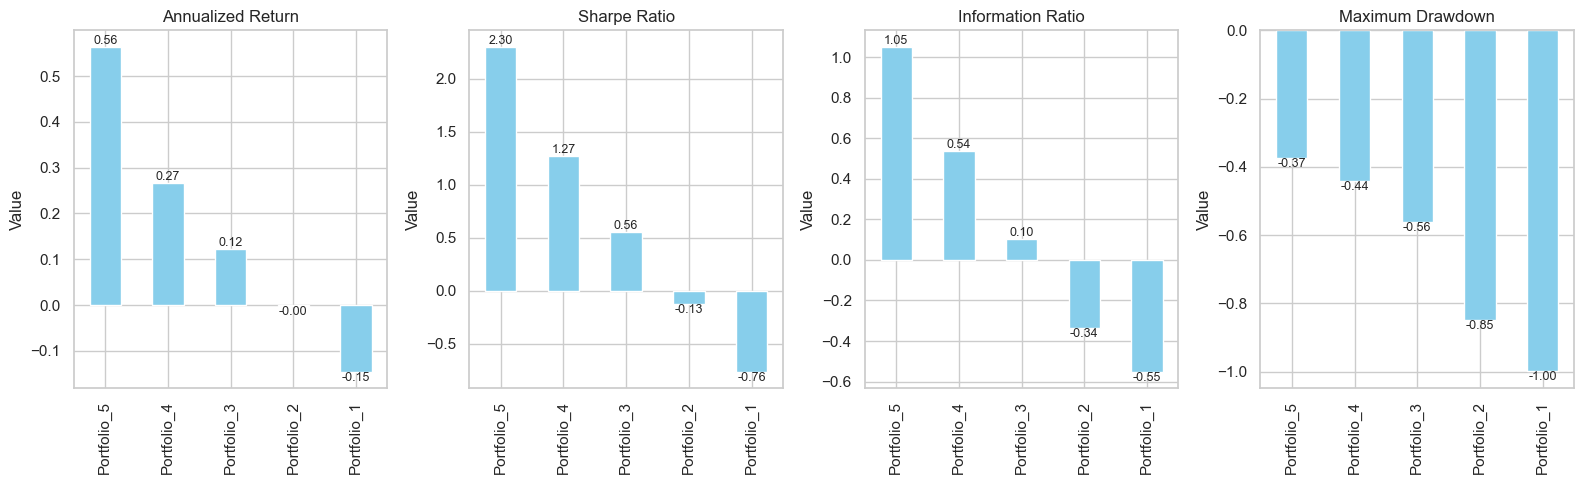

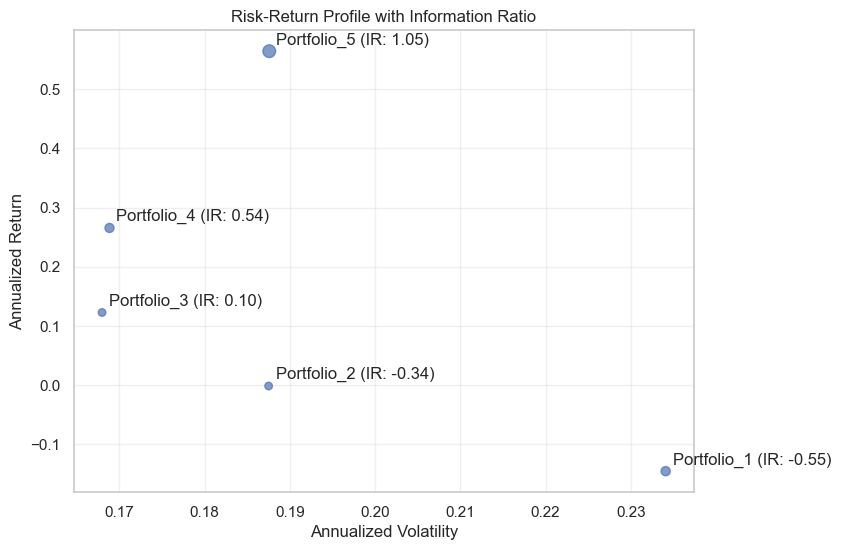

In [13]:
# Visualize and report results
def plot_portfolio_metrics(results_df):
    """
    Simple visualization for portfolio performance metrics.
    """
    # Set style
    sns.set(style="whitegrid")

    # 1. Create single row of key metric bar charts
    key_metrics = ['Annualized Return', 'Sharpe Ratio', 'Information Ratio', 'Maximum Drawdown']
    
    fig, axes = plt.subplots(1, len(key_metrics), figsize=(16, 5))
    
    # Sort portfolios by annualized return
    sorted_df = results_df.sort_values('Annualized Return', ascending=False)
    
    for i, metric in enumerate(key_metrics):
        ax = axes[i]
        sorted_df[metric].plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(metric)
        ax.set_ylabel('Value')
        
        # Add value labels
        for j, v in enumerate(sorted_df[metric]):
            ax.text(j, v, f"{v:.2f}", ha='center', 
                va='bottom' if v >= 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('C:\\Users\\magggien\\Documents\\Masters\\Quantative-Finance-and-Algorithmic-Trading\\results\\portfolio_metrics.png', dpi=300)
    
    # 2. Risk-Return scatter plot with added Information Ratio information
    plt.figure(figsize=(8, 6))
    
    # Use Information Ratio to determine point size
    sizes = sorted_df['Information Ratio'].apply(lambda x: max(abs(x) * 80, 30))
    
    plt.scatter(sorted_df['Annualized Volatility'], sorted_df['Annualized Return'], 
            s=sizes, alpha=0.7)
    
    for idx, row in sorted_df.iterrows():
        plt.annotate(f"{idx} (IR: {row['Information Ratio']:.2f})", 
                    (row['Annualized Volatility'], row['Annualized Return']),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Return')
    plt.title('Risk-Return Profile with Information Ratio')
    plt.grid(True, alpha=0.3)
    
    plt.savefig('C:\\Users\\magggien\\Documents\\Masters\\Quantative-Finance-and-Algorithmic-Trading\\results\\risk_return.png', dpi=300)
    plt.show()
        
plot_portfolio_metrics(backtester_results)

C:\Users\magggien\AppData\Local\Temp\ipykernel_3056\2160007954.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['alpha_annual'],


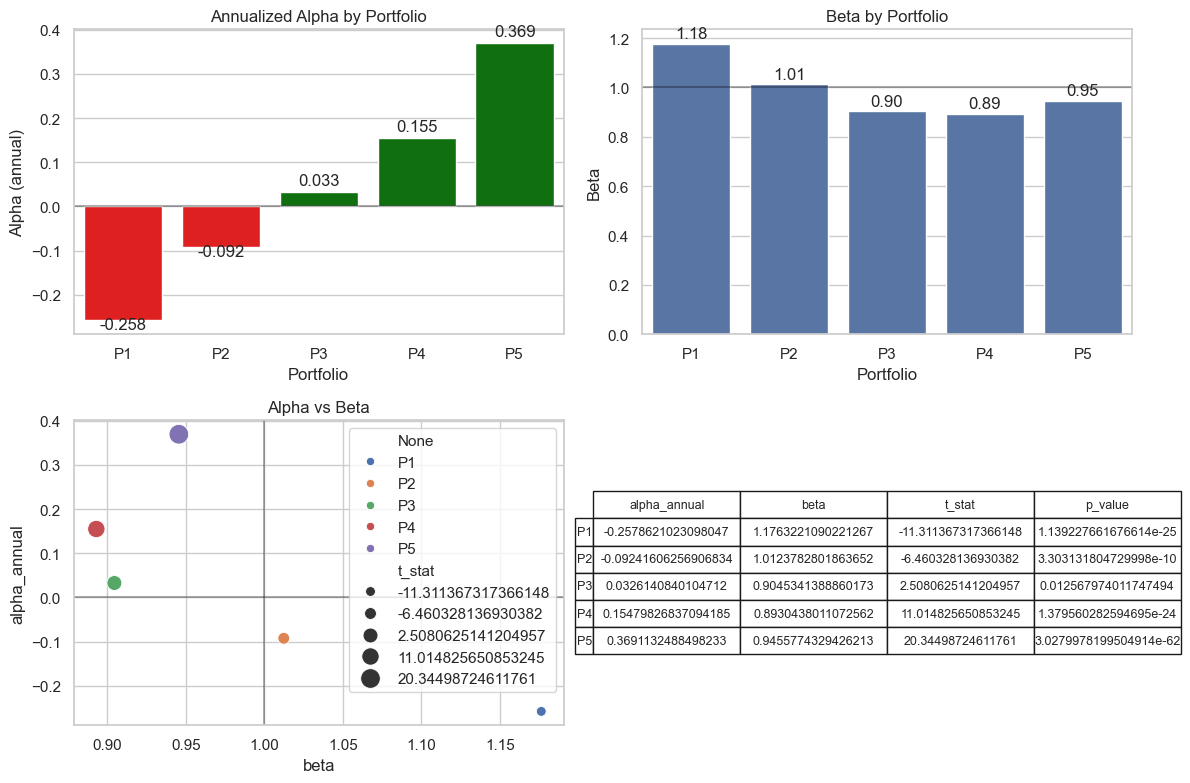

C:\Users\magggien\AppData\Local\Temp\ipykernel_3056\2160007954.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=results_df.index, y=results_df['alpha_annual'],


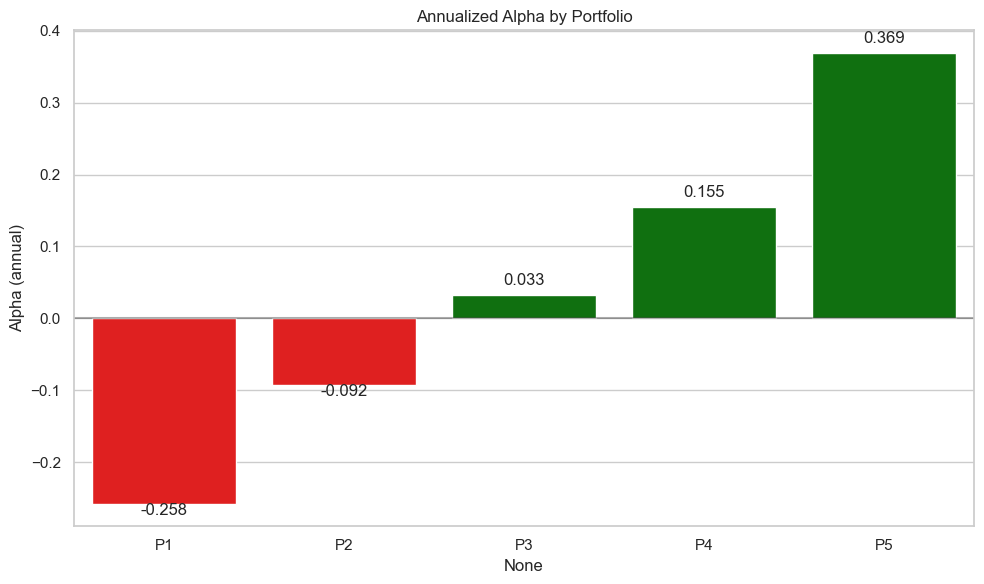

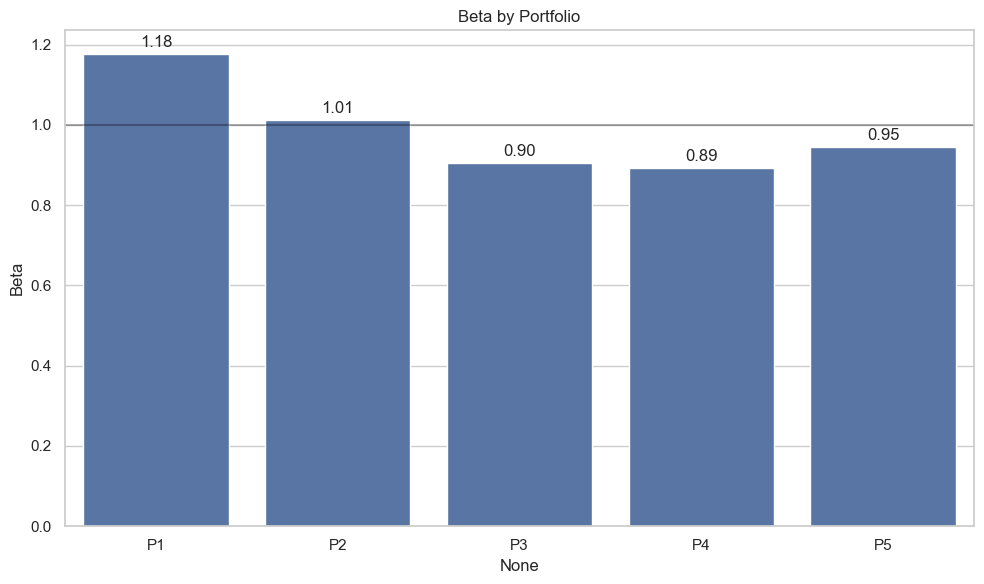

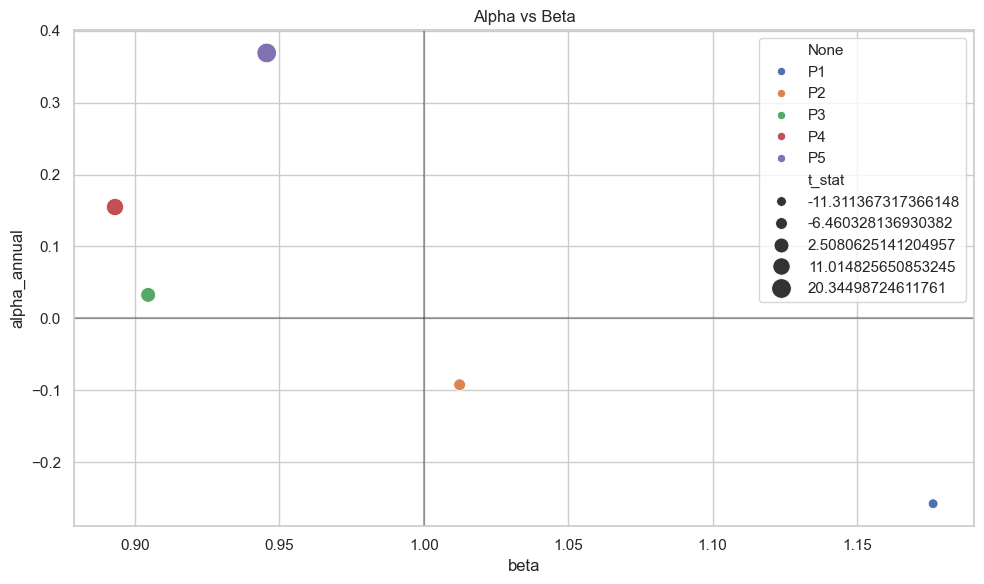

<function __main__.plot_stats_table(results_df)>

In [30]:
import statsmodels.api as sm
def calculate_and_visualize_alphas(portfolio_returns):
    # Dictionary to store results
    alphas = {}
    
    # For each portfolio
    for portfolio in ['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5']:
        # Extract data series
        dates = []
        excess_returns = []
        market_excess_returns = []
        
        # Collect data across all periods
        for date, portfolios in portfolio_returns.items():
            if portfolio in portfolios:
                dates.append(date)
                excess_returns.append(portfolios[portfolio]['excess_return'])
                market_excess_returns.append(portfolios[portfolio]['market_excess_return'])
        
        # Run regression if we have enough data
        if len(dates) > 1:
            X = sm.add_constant(market_excess_returns)
            model = sm.OLS(excess_returns, X).fit()
            
            # Extract alpha, beta and statistics
            alpha = model.params[0]
            beta = model.params[1]
            t_stat = model.tvalues[0]
            p_value = model.pvalues[0]
            
            # Annualize alpha (assuming monthly data)
            alpha_annual = alpha * 12
            
            alphas[portfolio] = {
                'alpha_monthly': alpha,
                'alpha_annual': alpha_annual,
                'beta': beta,
                't_stat': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            }
    
    # Create DataFrame for plotting
    results_df = pd.DataFrame(alphas).T
    results_df.index = [p.replace('Portfolio_', 'P') for p in results_df.index]
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Create a barplot for annual alpha
    ax1 = plt.subplot(2, 2, 1)
    sns.barplot(x=results_df.index, y=results_df['alpha_annual'], 
                palette=['green' if x > 0 else 'red' for x in results_df['alpha_annual']])
    plt.title('Annualized Alpha by Portfolio')
    plt.xlabel('Portfolio')
    plt.ylabel('Alpha (annual)')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(results_df['alpha_annual']):
        ax1.text(i, v + (0.01 if v >= 0 else -0.01), 
                f"{v:.3f}", ha='center', va='center' if v < 0 else 'bottom')
    
    # Create a barplot for beta
    ax2 = plt.subplot(2, 2, 2)
    sns.barplot(x=results_df.index, y=results_df['beta'])
    plt.title('Beta by Portfolio')
    plt.xlabel('Portfolio')
    plt.ylabel('Beta')
    plt.axhline(y=1, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(results_df['beta']):
        ax2.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
    
    # Create a scatterplot for alpha vs beta
    ax3 = plt.subplot(2, 2, 3)
    sns.scatterplot(x='beta', y='alpha_annual', hue=results_df.index, 
                    size='t_stat', sizes=(50, 200), data=results_df, ax=ax3)
    plt.title('Alpha vs Beta')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=1, color='black', linestyle='-', alpha=0.3)
    
    # Create a table for detailed statistics
    ax4 = plt.subplot(2, 2, 4)
    ax4.axis('off')
    table_data = results_df[['alpha_annual', 'beta', 't_stat', 'p_value']].round(3)
    table = ax4.table(cellText=table_data.values, 
                      rowLabels=table_data.index,
                      colLabels=table_data.columns,
                      cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    plt.tight_layout()
    plt.savefig('portfolio_alphas.png', dpi=300)
    plt.show()
    
    return alphas, results_df
alphas, alpha_df = calculate_and_visualize_alphas(portfolio_returns)

def calculate_alphas(portfolio_returns):
    # Dictionary to store results
    alphas = {}
    
    # For each portfolio
    for portfolio in ['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5']:
        # Extract data series
        dates = []
        excess_returns = []
        market_excess_returns = []
        
        # Collect data across all periods
        for date, portfolios in portfolio_returns.items():
            if portfolio in portfolios:
                dates.append(date)
                excess_returns.append(portfolios[portfolio]['excess_return'])
                market_excess_returns.append(portfolios[portfolio]['market_excess_return'])
        
        # Run regression if we have enough data
        if len(dates) > 1:
            X = sm.add_constant(market_excess_returns)
            model = sm.OLS(excess_returns, X).fit()
            
            # Extract alpha, beta and statistics
            alpha = model.params[0]
            beta = model.params[1]
            t_stat = model.tvalues[0]
            p_value = model.pvalues[0]
            
            # Annualize alpha (assuming monthly data)
            alpha_annual = alpha * 12
            
            alphas[portfolio] = {
                'alpha_monthly': alpha,
                'alpha_annual': alpha_annual,
                'beta': beta,
                't_stat': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            }
    
    # Create DataFrame for plotting
    results_df = pd.DataFrame(alphas).T
    results_df.index = [p.replace('Portfolio_', 'P') for p in results_df.index]
    
    return alphas, results_df

alphas, alpha_df = calculate_alphas(portfolio_returns)

def plot_annual_alpha(results_df):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=results_df.index, y=results_df['alpha_annual'], 
                palette=['green' if x > 0 else 'red' for x in results_df['alpha_annual']])
    plt.title('Annualized Alpha by Portfolio')
    plt.ylabel('Alpha (annual)')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(results_df['alpha_annual']):
        ax.text(i, v + (0.01 if v >= 0 else -0.01), 
                f"{v:.3f}", ha='center', va='center' if v < 0 else 'bottom')
    
    plt.tight_layout()
    plt.savefig('portfolio_annual_alpha.png', dpi=300)
    plt.show()

# Beta Bar Plot
def plot_beta(results_df):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=results_df.index, y=results_df['beta'])
    plt.title('Beta by Portfolio')
    plt.ylabel('Beta')
    plt.axhline(y=1, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(results_df['beta']):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('portfolio_beta.png', dpi=300)
    plt.show()

# Alpha vs Beta Scatter Plot
def plot_alpha_vs_beta(results_df):
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(x='beta', y='alpha_annual', hue=results_df.index, 
                size='t_stat', sizes=(50, 200), data=results_df)
    plt.title('Alpha vs Beta')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=1, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('portfolio_alpha_vs_beta.png', dpi=300)
    plt.show()

# Statistics Table
def plot_stats_table(results_df):
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.axis('off')
    table_data = results_df[['alpha_annual', 'beta', 't_stat', 'p_value']].round(3)
    table = ax.table(cellText=table_data.values, 
                  rowLabels=table_data.index,
                  colLabels=table_data.columns,
                  cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    plt.tight_layout()
    plt.savefig('portfolio_stats_table.png', dpi=300)
    plt.show()
    
    
plot_annual_alpha(alpha_df)
plot_beta(alpha_df)
plot_alpha_vs_beta(alpha_df)
plot_stats_table